# Multigraph Representation Learning

Say you're a brain researcher, and you have a bunch of scans of people's brains - some are scans of normal people, and some are scans of people with Abnormal Disease. You have an algorithm that lets you create networks from these brains, so you turn all your brain scans into networks. You want to know if the scans from the abnormal group are more similar to each other than to the scans from normal people. What do you do? It seems like your abnormal networks should look different than normal networks, but how can you actually test this? How do you even deal with situations in which you have a lot of networks whose nodes all represent the same objects, but which might look quite different?

Well, one thing that you could do is embed your networks and then try to learn from the embeddings. This would serve the dual purpose of having less stuff to deal with, as well as having some way to directly compare embeddings. Say you have nine networks of normal brains, and nine networks of abnormal brains.

In [22]:
import numpy as np
from graspologic.simulations import sbm

# Generate networks from an SBM, given some parameters
def make_network(*probs, n=100, return_labels=False):
    p1, p2, p3, p4 = probs
    P = np.array([[p1, p2], [p3, p4]])
    return sbm([n, n], P, return_labels=return_labels)

p1, p2, p3 = .12, .06, .03
n = 100
normals = [make_network(p1, p3, p3, p1, n=n) for i in range(9)]
abnormals = [make_network(p3, p1, p1, p3, n=n) for i in range(9)]

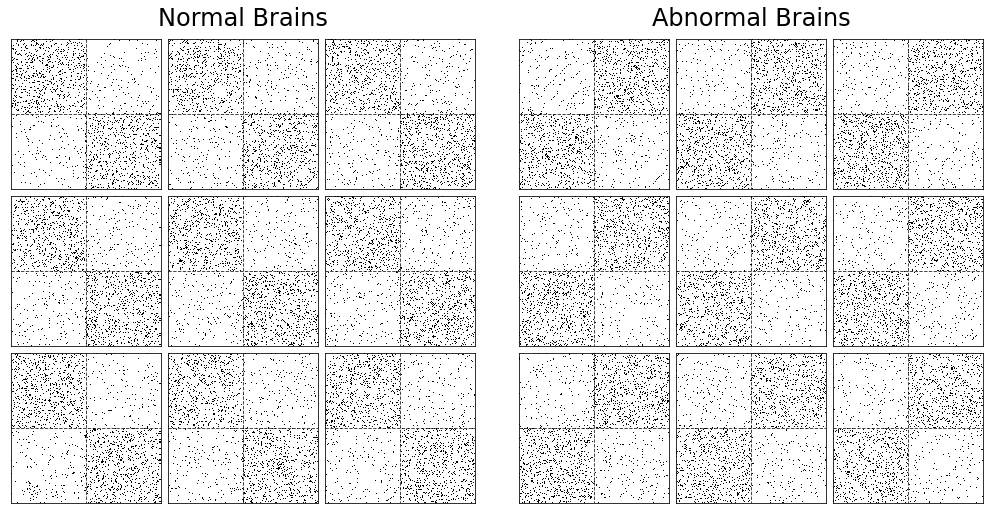

In [23]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from graspologic.plot import binary_heatmap, adjplot
import warnings
warnings.filterwarnings("ignore")

fig = plt.figure(figsize=(14,7))

grid1 = ImageGrid(fig, 121, (3, 3), axes_pad=.1, share_all=True)
grid2 = ImageGrid(fig, 122, (3, 3), axes_pad=.1, share_all=True)

for i, (axi, axj) in enumerate(zip(grid1, grid2)):
    hmn = binary_heatmap(normals[i], ax=axi, cbar=False)
    hma = binary_heatmap(abnormals[i], ax=axj, cbar=False)
    for ax in [hmn, hma]:
        for spine in ax.spines.values():
            spine.set_visible(True)    
        ax.vlines(n, 0, n*2, colors="black", lw=.9, linestyle="dashed", alpha=.8)
        ax.hlines(n, 0, n*2, colors="black", lw=.9, linestyle="dashed", alpha=.8)

grid1.axes_all[1].set_title("Normal Brains", fontsize=24, y=1.05)
grid2.axes_all[1].set_title("Abnormal Brains", fontsize=24, y=1.05)

plt.tight_layout(w_pad=3)

The most obvious way to embed these networks is by averaging them, and then embedding the result of that averaging. It turns out that this is actually not only the right thing to do, but the optimal thing to do if your networks are all drawn from the same distribution. In our case, averaging only the normal networks together, and averaging only the abnormal networks together, will produce two embeddings that are as good as possible.

In [24]:
from graspologic.embed import AdjacencySpectralEmbed as ASE

# Compute the average adjacency matrix for 
# normal brains and alzheimer's brains
normal_mean = np.array(normals).mean(axis=0)
abnormal_mean = np.array(abnormals).mean(axis=0)

# Embed both matrices
ase = ASE(n_components=2)
latents_normal = ase.fit_transform(normal_mean)
latents_abnormal = ase.fit_transform(abnormal_mean)

<AxesSubplot:title={'center':"Embedding when we average the \nalzheimer's graphs"}>

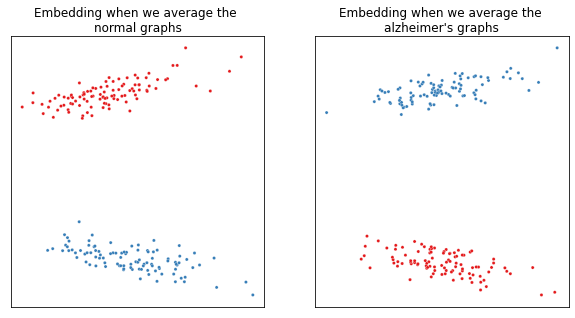

In [25]:
import seaborn as sns

def plot_latents(latent_positions, *, title, labels, ax=None, legend=False):
    if ax is None:
        ax = plt.gca()
    plot = sns.scatterplot(latent_positions[:, 0], latent_positions[:, 1], hue=labels, 
                           s=10, ax=ax, palette="Set1")
    plot.set_title(title, wrap=True);
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
    if legend:
        ax.legend(loc="upper right", title="Community")
    else:
        ax.get_legend().remove()
    
    return plot

# plot
labels = [0]*n + [1]*n
fig, axs = plt.subplots(ncols=2, figsize=(10, 5))
plot_latents(latents_normal, title="Embedding when we average the \nnormal graphs", 
             labels=labels, ax=axs[0])
plot_latents(latents_abnormal, title="Embedding when we average the \nalzheimer's graphs", 
             labels=labels, ax=axs[1])

Both of these embeddings look great. But what if we wanted to embed *all* of the networks into the same space? Let's try it. We can take all of the networks, both normal and abnormal ones, and then average them together. This results in a single embedding.

In [30]:
total_mean = np.array(normals + abnormals).mean(axis=0)
latents_everything = ase.fit_transform(total_mean)

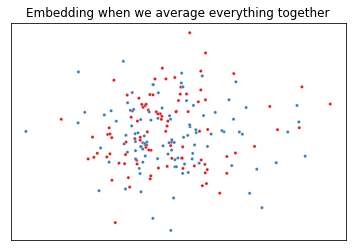

In [32]:
plot_latents(latents_everything, title="Embedding when we average everything together", 
             labels=labels);

Bummer. What we've just discovered is that, even though it's a great idea to simply average a bunch of networks if they were drawn from the same distribution, there are some situations in which averaging your networks simply results in meaningless noise. This is a case of averaging networks which are "heterogeneous". This means that not only are your networks slightly different, but they're *expected* to be different: they come from different distributions. So if you sampled a lot of networks, like we just did, then averaging them would produce poor results.

We'd like to find a way to compare these heterogeneous networks directly, and to embed them all into the same space. Figuring out the best way to do this is a topic under active research, and the set of techniques and tools that have developed as a result are together called multigraph representation learning (here, "graph" just means "network").

In this section, we'll explore the strengths and weaknesses of different types of multigraph representation learning. Multiple Adjacency Spectral Embedding (MASE) is a technique which embeds a bunch of networks separately (with normal Adjacency Spectral Embedding), and then re-embeds all the separate results into a single space. MASE is nice because you don't actually need each network to be generated from the same distribution - you only need the nodes of the different networks to be aligned and for them to belong to the same communities. Omnibus embedding combines the adjacency matrix of all of the matrices into a single super-matrix, and then embeds that super-matrix.

## Multiple Adjacency Spectral Embedding

The first algorithm we'll explore is called MASE, and is probably the easiest to understand if you know how Adjacency Spectral Embeddings work. Say you have some number of networks, and (like we said above) their nodes are aligned. The goal of MASE is to embed the networks into a single space, with each point in that space representing a single node - but, unlike simply averaging, your networks don't necessarily have to be drawn from the same distribution. MASE is based on the common subspace independent-edge (COSIE) model from the multi-network models section of chapter 5, so we're operating under the assumption that there *is* some low-dimensional space common to all of our networks that we can embed into in the first place.

The figure below shows how MASE works under the hood. First, we embed the adjacency matrices of a bunch of networks separately. Then, we take all of those embeddings, concatenate them into a single matrix, and embed the entire concatenated matrix.

```{figure} ../../Images/mase1.jpeg
---
height: 400px
name: mase-fig
---
The MASE algorithm
```

### A Collection of Networks

Suppose we have a set of networks generated from Stochastic Block Models with two communities in each network. The networks have aligned nodes -- meaning that the $i_{th}$ row of all of their adjacency matrices represent the same nodes. The nodes also all belong to the same communities. However, edge probabilities might change depending on the network - in the first network, you might have nodes in the same community having a high chance of connecting to each other, whereas in the second network, nodes are much more likely to be connected to other nodes in different communities. Your goal is to find a common space in which to represent all of these networks, that captures the common community structure in all of these.

Below is Python code which generates four networks with Stochastic Block Models. The labels are the same across the networks (which means that nodes have a consistent community no matter which network you're looking at), but the block probability matrices are quite different.

In [13]:
import warnings
warnings.filterwarnings("ignore")

In [1]:
import numpy as np
from graspologic.simulations import sbm

n = 100
p1, p2, p3 = .12, .06, .03
A1, labels = make_sbm(p1, p3, p3, p1, 
                      return_labels=True)
A2 = make_sbm(p1, p3, p3, p2)
A3 = make_sbm(p3, p2, p2, p3)
A4 = make_sbm(p1, p3, p3, p3)

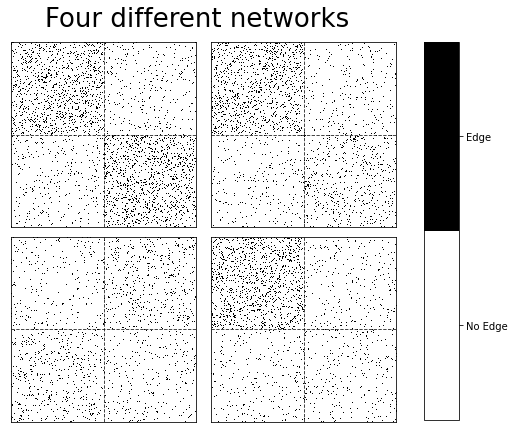

In [11]:
from graspologic.plot import binary_heatmap
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap


fig, axs = plt.subplots(2, 2, figsize=(7,7))
for ax, graph in zip(axs.flat, [A1, A2, A3, A4]):
    hmap = binary_heatmap(graph, ax=ax, cbar=False)
    for spine in ax.spines.values():
        spine.set_visible(True)
    hmap.vlines(n, 0, n*2, colors="black", lw=.9, linestyle="dashed", alpha=.8)
    hmap.hlines(n, 0, n*2, colors="black", lw=.9, linestyle="dashed", alpha=.8)
    
plt.suptitle("Four different networks", fontsize=26, y=.95)
fig.subplots_adjust(hspace=.05, wspace=.05)

cmap = ListedColormap(["white", "black"])
cbar_ax = fig.add_axes([.95, 0.13, 0.07, 0.75])
cbar = fig.colorbar(hmap.imshow(A1, cmap=cmap), cax=cbar_ax)
cbar.set_ticks([0.25, 0.75])
cbar.set_ticklabels(["No Edge", "Edge"])

Now, we want to embed each of the four networks separately. Doing this lets us see what the individual embeddings of the networks each look like. We'll also need these embeddings to unify the networks all into a single space.

In [14]:
from graspologic.embed import AdjacencySpectralEmbed as ASE

networks = [A1, A2, A3, A4]
latents = []
for network in networks:
    ase = ASE(n_components=2)
    latent = ase.fit_transform(network)
    latents.append(latent)

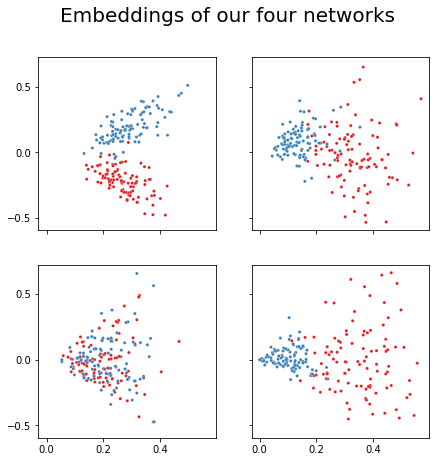

In [18]:
fig, axs = plt.subplots(2, 2, figsize=(7,7), sharex=True, sharey=True)
for i, ax in enumerate(axs.flat):
    plot_latents(latents[i], title=None, labels=labels, ax=ax)
    ax.yaxis.set_major_locator(plt.MaxNLocator(3))
plt.suptitle("Embeddings of our four networks", fontsize=20);

# TODO: add legend

Now, we want to take these individual embeddings, concatenate them into a single matrix, and then embed the result.

In [27]:
from graspologic.embed import selectSVD

concatenated = np.hstack(latents)
joint_embedding, *_ = selectSVD(concatenated, n_components=2)

<AxesSubplot:title={'center':'Joint embedding of our four networks'}>

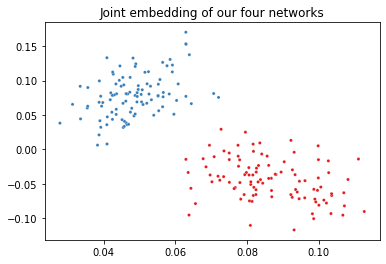

In [27]:
plot_latents(joint_embedding, title="Joint embedding of our four networks",
             labels=labels)

## Using Graspologic

<AxesSubplot:title={'center':'MASE embedding'}>

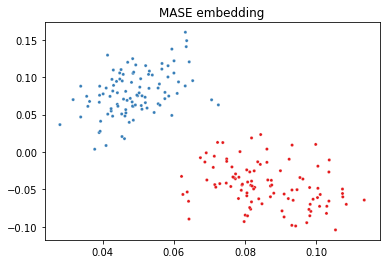

In [28]:
from graspologic.embed import MultipleASE as MASE

mase = MASE(n_components=2)
latents = mase.fit_transform(networks)

plot_latents(latents, title="MASE embedding", labels=labels)